<a href="https://colab.research.google.com/github/luisanovaes/ufam_project/blob/main/topic_model_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Topification

In [ ]:
!pip install bertopic==0.12.0
!pip install pyspark
!pip install keyphrase-vectorizers
!pip install top2vec
!pip install sentence-transformers
!pip install gensim==4.2.0
!pip install joblib==1.1.0
!pip install --upgrade pip


In [ ]:
import gensim
print(gensim.__version__)

4.2.0


## Import JusBERTopic

In [ ]:
from numpy.lib.npyio import save
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from sklearn.feature_extraction.text import CountVectorizer
from keyphrase_vectorizers import KeyphraseCountVectorizer

class jusBERTopic:
    def __init__(self, seed=2021):
        self.model = None
        self.seed = seed
        self.top_n_words = 20
        nltk.download('punkt')

        import torch
        torch.manual_seed(self.seed)
        torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def train_doc2vec(self, documents):
        min_count = 50
        hs = 1
        negative = 0
        epochs = 40
        doc2vec_args = {"vector_size": 300,
                        "min_count": min_count,
                        "window": 15,
                        "sample": 1e-5,
                        "negative": negative,
                        "hs": hs,
                        "epochs": epochs,
                        "dm": 0,
                        "dbow_words": 1}

        tokenized_doc = []
        for d in documents:
            tokenized_doc.append(word_tokenize(d, language='english'))
        # Convert tokenized document into gensim formated tagged data
        tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
        model = Doc2Vec(**doc2vec_args)
        model.build_vocab(tagged_data)
        model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
        return model

    def doc2vec_infer(corpus, model_path):
      # load doc2vec model
      d2v_model = Doc2Vec.load(model_path)
      embedding_model = d2v_model.wv
      # tokenize documents
      tokenized_doc = [word_tokenize(d, language='english') for d in corpus]
      doc_infer = d2v_model.infer_vector(tokenized_doc[0], steps=40)
      embedding = [doc_infer]
      for document in tokenized_doc[1:]:
          doc_infer = d2v_model.infer_vector(document, steps=40)
          embedding = np.append(embedding, [np.array(doc_infer)], axis=0)
      return embedding_model, embedding        

    def build_model(self, option, documents, embed_documents, lm_path, calculate_probabilities=False): 
        if option == 'sentence':  # sentence transformer
            emb_model = SentenceTransformer(lm_path)
            embedding_model = emb_model
            embedding = emb_model.encode(embed_documents, show_progress_bar=True)
        elif option == 'doc2vec':
            print('Executing bertopic + doc2vec')
            try:
            # load pre-trained doc2vec model
              model = np.load('content/drive/MyDrive/Colab-Notebooks/luisa-novaes/embedding-vector.npy')
            except:
              model = self.train_doc2vec(documents=documents)
              embedding_model = model.wv
              embedding = model.dv.vectors
            #np.save('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/embedding-vector', embedding)
            #print(embedding)
        else:  # default
            embedding_model = None
            embedding = None

        print('Done creating embeddings.')

        self.top_n_words = 20
        # initialize model
        self.model = BERTopic(language='english',
                              top_n_words=self.top_n_words,
                              calculate_probabilities=calculate_probabilities,
                              embedding_model=embedding_model,
                              n_gram_range=(1, 2),
                              verbose=True,
                              diversity=0.1)
        print('Done initializing bertopic.')

        # fit model to documents
        topics, probabilities = self.model.fit_transform(documents=documents, embeddings=embedding)

        print(self.model.get_topic_freq())
        return self.model, topics, probabilities

    def get_word_distribution_per_topic(self):
        topics = self.model.get_topics()
        all_topics = {}
        for topic_id in topics.keys():
            words = []
            for item in topics[topic_id]:
                words.append(item[0])
            all_topics[topic_id] = words
        return all_topics

    def get_num_topics(self):
        return len(self.model.get_topics())

    def print_topics(self):
        list_of_words = []
        topics = self.model.get_topics()
        all_topics = {}
        for topic_id in topics.keys():
            words = []
            for item in topics[topic_id]:
                words.append(item[0])
            if topic_id != -1:
                new_words = [x for x in words if x != '']
                list_of_words.append(new_words)
            print(f"Topic %d: {words}" % topic_id)
        return list_of_words

    def stats_topic_per_document(self, all_topics, contribution, corpus, doc_ids_list):
        # Init output
        topic_csv_df = pd.DataFrame()
        doc_csv_df = pd.DataFrame()

        words_per_topic = self.get_word_distribution_per_topic()

        topic_num = pd.Series(all_topics)
        topic_num.astype(int)
        max_score = pd.Series(contribution)
        max_score = np.round(max_score, 4)
        doc_csv_df = pd.concat([topic_num, max_score], axis=1)
        doc_csv_df.columns = ['Dominant_Topic', 'Perc_Contribution']

        # adding document id and numero unificado
        juris_ids = pd.Series(doc_ids_list)
        doc_csv_df = pd.concat([juris_ids, doc_csv_df], axis=1)

        # Add original text to the end of the output
        contents = pd.Series(corpus)
        doc_csv_df = pd.concat([doc_csv_df, contents], axis=1)

        # Format
        doc_csv_df.columns = ['Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Document']

        # ignoring the topic -1
        for topic_num in range(0, len(words_per_topic)-1):
            wp = words_per_topic[topic_num]
            topic_keywords = ", ".join([word for word in wp])
            topic_csv_df = topic_csv_df.append(pd.Series([topic_num, topic_keywords]), ignore_index=True)
        topic_csv_df.columns = ['Topic', 'Keywords']

        return doc_csv_df, topic_csv_df

    def stats_topic_per_document_with_probabilities(self, contribution, corpus, doc_ids_list):
        # Init output
        topic_csv_df = pd.DataFrame()
        doc_csv_df = pd.DataFrame()

        words_per_topic = self.get_word_distribution_per_topic()

        # Get main topic in each document
        for i, row in enumerate(contribution):
            # For now I am ignoring this feature of BERTopic, that is to return topic = -1  for outliers
            # (documents that do not have a topic assigned)
            max_score = np.max(row)
            topic_num = np.argmax(row)

            #ind = np.argpartition(row, -20)[-20:]
            #top5 = ind[np.argsort(row[ind])]
            #top5 = np.flip(top5)
            top5 = np.flip(np.argsort(row))
            doc_csv_df = doc_csv_df.append(pd.Series([int(topic_num), round(max_score, 4), top5]), ignore_index=True)
        doc_csv_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Top5_Topics']

        # adding document id and numero unificado
        juris_ids = pd.Series(doc_ids_list)
        doc_csv_df = pd.concat([juris_ids, doc_csv_df], axis=1)

        # Add original text to the end of the output
        contents = pd.Series(corpus)
        doc_csv_df = pd.concat([doc_csv_df, contents], axis=1)

        # Format
        #doc_csv_df = doc_csv_df.reset_index()
        doc_csv_df.columns = ['Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Top5_Topics', 'Ementa']

        # ignoring the topic -1
        for topic_num in range(0, len(words_per_topic)-1):
            wp = words_per_topic[topic_num]
            topic_keywords = ", ".join([word for word in wp])
            topic_csv_df = topic_csv_df.append(pd.Series([topic_num, topic_keywords]), ignore_index=True)
        topic_csv_df.columns = ['Topic', 'Keywords']

        return doc_csv_df, topic_csv_df

    def array_to_string(self, my_list):
        return ", ".join([word for word in my_list])

    def stats_topic_per_document_spark(self, spark, all_topics, contribution, corpus, doc_ids_list):
        contribution = [float(np.round(i, 4)) for i in contribution]
        dfSchema = StructType([
            StructField("Document_id", StringType(), True),
            StructField("Dominant_Topic", IntegerType(), True),
            StructField("Topic_Perc_Contrib", DoubleType(), True),
            StructField("Document", StringType(), True)
        ])
        data = zip(doc_ids_list, all_topics, contribution, corpus)
        columns = ['Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Document']
        doc_csv_df = spark.createDataFrame(data, columns, dfSchema)
        doc_csv_df.withColumn("Dominant_Topic", col("Dominant_Topic").cast("int"))

        words_per_topic = self.get_word_distribution_per_topic()
        array_to_string_udf = udf(self.array_to_string, StringType())
        dfTopicsSchema = StructType([
            StructField("Topic", StringType(), True),
            StructField("Keywords", StringType(), True)
        ])
        columns = ['Topic', 'Keywords']
        data = zip(words_per_topic.keys(), words_per_topic.values())
        topic_csv_df = spark.createDataFrame(data, columns, dfTopicsSchema)
        topic_csv_df = topic_csv_df.withColumn('Keywords', array_to_string_udf(topic_csv_df["Keywords"]))
        return doc_csv_df, topic_csv_df


In [ ]:
#Função indicando o caminho dos arquivos .py que chamaremos embaixo
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/tm_geral-main')

from glob import glob
import os
import re

In [ ]:
#JusTop2Vec

# https://github.com/ddangelov/Top2Vec

from top2vec import Top2Vec
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType


class jusTop2Vec:
    def __init__(self, language_model='universal-sentence-encoder-multilingual', seed=2021):
        self.LM = language_model
        self.seed = seed

        import torch
        torch.manual_seed(self.seed)
        torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def train(self, documents):
        return Top2Vec(documents, embedding_model=self.LM)

    def get_num_topics(self, model):
        return model.get_num_topics()

    def print_topics(self, model, num_topics=None):
        """
        Print word distribution per topic

        :parameters:
            num_topics: number of topics
        """
        topics_words, word_scores, topic_nums = model.get_topics(num_topics)

        for topic in topic_nums:
            print(f"Topic %d: {topics_words[topic]}" % topic)

    def get_word_distribution_per_topic(self, model, num_topics=None):
        """
        Get distribution of words per topic

        :parameters:
            num_topics: number of topics

        :return:
           distribution of words per topics
        """
        topics_words, word_scores, topic_nums = model.get_topics(num_topics)
        all_topics = {}
        for topic in topic_nums:
            all_topics[topic] = topics_words[topic]
        return all_topics

    def get_topics_per_doc(self, model, total_num_docs):
        """
        Get distribution of topics per document

        :return:
           topic per document
        """
        topic_per_document = []
        for doc_id in range(0, total_num_docs):
            doc_topics, doc_dist, topic_words, topic_word_scores = model.get_documents_topics([doc_id])
            topic_per_document.append((doc_topics[0], doc_dist[0]))
        return topic_per_document

    def show_wordcloud(self, model, topic_id):
        model.generate_topic_wordcloud(topic_id)

    def search_documents_by_topic(self, model, topic_num=0, num_docs=10):
        return model.search_documents_by_topic(topic_num, num_docs)

    def get_keywords_per_topic(self, model, num_topics=1, top_n=10):
        keywords = {}
        words_per_topic = self.get_word_distribution_per_topic(model, num_topics=num_topics)
        for k in range(0, num_topics):
            wp = words_per_topic[k]
            keywords[k] = [word for word in wp[0:top_n]]
        return keywords

    def stats_topic_per_document(self, model, corpus, doc_ids_list, num_topics=1, top_n_words=10):
        # Init output
        topic_csv_df = pd.DataFrame()
        doc_csv_df = pd.DataFrame()

        topics_per_doc = self.get_topics_per_doc(model, len(corpus))
        words_per_topic = self.get_word_distribution_per_topic(model, num_topics=num_topics)

        # Get main topic in each document
        for i, row in enumerate(topics_per_doc):
            topic_num = row[0]
            max_score = row[1]
            doc_csv_df = doc_csv_df.append(pd.Series([int(topic_num), round(max_score, 4)]), ignore_index=True)
        doc_csv_df.columns = ['Dominant_Topic', 'Perc_Contribution']

        # adding document id and numero unificado
        juris_ids = pd.Series(doc_ids_list)
        doc_csv_df = pd.concat([juris_ids, doc_csv_df], axis=1)

        # Add original text to the end of the output
        contents = pd.Series(corpus)
        doc_csv_df = pd.concat([doc_csv_df, contents], axis=1)

        # Format
        doc_csv_df.columns = ['Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Document']

        for topic_num in range(0, len(words_per_topic)):
            wp = words_per_topic[topic_num]
            topic_keywords = ", ".join([word for word in wp[0:top_n_words]])
            topic_csv_df = topic_csv_df.append(pd.Series([topic_num, topic_keywords]), ignore_index=True)
        topic_csv_df.columns = ['Topic', 'Keywords']

        return doc_csv_df, topic_csv_df

    def array_to_string(self, my_list, top_n_words):
        print(my_list)
        return ", ".join([word for word in my_list[0:top_n_words]])

    def stats_topic_per_document_spark(self, spark, model, corpus, doc_ids_list, num_topics=1, top_n_words=10):
        topics_per_doc = self.get_topics_per_doc(model, len(corpus))
        words_per_topic = self.get_word_distribution_per_topic(model, num_topics=num_topics)
        list_topics_per_doc = list(map(list, zip(*topics_per_doc)))
        list_topics_per_doc[0] = [int(i) for i in list_topics_per_doc[0]]
        list_topics_per_doc[1] = [float(i) for i in list_topics_per_doc[1]]
        dfSchema = StructType([
            StructField("Document_id", StringType(), True),
            StructField("Dominant_Topic", IntegerType(), True),
            StructField("Topic_Perc_Contrib", DoubleType(), True),
            StructField("Document", StringType(), True)
        ])
        data = zip(doc_ids_list, list_topics_per_doc[0], list_topics_per_doc[1], corpus)
        columns = ['Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Document']
        doc_csv_df = spark.createDataFrame(data, columns, dfSchema)
        doc_csv_df.withColumn("Dominant_Topic", col("Dominant_Topic").cast("int"))

        topics = list(map(int, words_per_topic.keys()))
        list_of_words = [self.array_to_string(words, top_n_words) for words in words_per_topic.values()]
        dfTopicsSchema = StructType([
            StructField("Topic", StringType(), True),
            StructField("Keywords", StringType(), True)
        ])
        columns = ['Topic', 'Keywords']
        data = zip(topics, list_of_words)
        topic_csv_df = spark.createDataFrame(data, columns, dfTopicsSchema)
        topic_csv_df = topic_csv_df.withColumn('Keywords', topic_csv_df["Keywords"])

        return doc_csv_df, topic_csv_df


In [ ]:
import argparse
import re
import unicodedata
import nltk
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
#from jusTop2Vec import jusTop2Vec
#from jusBERTopic import jusBERTopic
from sklearn.feature_extraction.text import CountVectorizer



class LoadData:
    def load_data(self):
        documents = []
        list_of_ids = []
        i=0
      
        mypath = '/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/Coliee_2021'
        for txt in glob(os.path.join(mypath, '*.txt')):
          with open(txt) as tfile:
            text = tfile.read()         
            text = text.replace('\n',' ').replace('FRAGMENT_SUPPRESSED','')
            documents.append(text)
            list_of_ids.append(txt)
            list_of_ids[:] = [d.replace('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/Coliee_2021/','') for d in list_of_ids]
     
        return documents, list_of_ids

# prepare data to run topic modeling solution
class PreprocessingData:
    def __init__(self, min_df=1, max_df=0.75, token_pattern=r"[a-zA-Z]\w*"): ##Mexer nisso?
        self.min_df = min_df
        self.max_df = max_df
        self.token_pattern = token_pattern
        # list of stop words in english
        nltk.download('stopwords')
        self.en_stopwords = nltk.corpus.stopwords.words('english') # Mudado 
        self.en_stopwords.extend(['refd'])  # Add 'refd' as stopword 


    def remove_punctuation(self, text):
        """
        Remove punctuations

        :parameters:
            text: sentence (string)

        :return: preprocessed documents without punctuations
        """
        punctuation = r'[/.!$%^&#*+\'\"()-.,:;<=>?@[\]{}|]'
        return re.sub(punctuation, '', text)

    def strip_accents_from_word(self, text):
        """
        Strip accents from input String.

        :parameters:
            text: word (string)

        :return: preprocessed word without accent
         """
        text = unicodedata.normalize('NFD', text)
        text = text.encode('ascii', 'ignore')
        text = text.decode("utf-8")
        return str(text)

    def strip_accents(self, text):
        """
        Strip accents from text.

        :parameters:
            text: sentence (string)

        :return: preprocessed documents without accent
         """
        return " ".join([self.strip_accents_from_word(word) for word in text.split()])

    def remove_URL(self, text):
        """
        Remove URLs from text
        :return: text without URLs
        """
        return re.sub(r"<.*?>", " ", text)

    def clean_text(self, documents):
        """
        Clean (preprocess) text data: parse URL, remove punctuation, convert to lowercase, remove stopword, and
        strip accents
        :param documents: list of documents
        :return: preprocessed_text: list of preprocessed documents
        """
        # preprocess jusbrasil URLs
        preprocessed_text = []
        for text in documents:
            preprocessed_text.append(self.remove_URL(text))
        # We have to decide whether we want to remove or keep punctuation
        # agravodeinstrumentoai70068698984rs or lei_de_criacao_do_pis_lei_complementar_7_70
        preprocessed_text = [self.remove_punctuation(doc) for doc in preprocessed_text]
        # convert to lowercase
        preprocessed_text = [doc.lower() for doc in preprocessed_text]
        # remove stopwords
        preprocessed_text = [' '.join([w for w in doc.split() if len(w) > 1 and w not in self.en_stopwords])
                             for doc in preprocessed_text]
        # strip accents
        # preprocessed_text = [self.strip_accents(doc) for doc in preprocessed_text]
        return preprocessed_text

    def prepare_text_for_topicmodel(self, documents, list_doc_ids):
        """
        Prepare data for BERTopic topic discovery
        :param documents: list of documents
        :param list_doc_ids: list of documents' ids
        :return: preprocessed_docs: list of preprocessed documents
                 ids_docs_removed: list of ids to be removed
        """
        # clean the data: parser URL, lowercase, remove punctuation, and remove stopwords
        preprocessed_docs_tmp = self.clean_text(documents)

        # stop_word = None. Stopwords were removed in clean_text()
        vectorizer = CountVectorizer(stop_words=None,
                                     tokenizer=None,
                                     min_df=self.min_df,
                                     max_df=self.max_df,
                                     ngram_range=(1, 2),
                                     token_pattern=self.token_pattern,
                                     lowercase=True)

        vectorizer.fit_transform(preprocessed_docs_tmp)
        vocabulary = set(vectorizer.get_feature_names())

        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if w.lower() in vocabulary])
                                 for doc in preprocessed_docs_tmp]

        list_ids_removed = []
        preprocessed_docs, unpreprocessed_docs = [], []
        for i, doc in enumerate(preprocessed_docs_tmp):
            if len(doc) > 0:
                preprocessed_docs.append(doc)
                unpreprocessed_docs.append(documents[i])
            else:
                list_ids_removed.append(list_doc_ids[i])

        return preprocessed_docs, list_ids_removed


class TopicModel:
    def __init__(self, corpus=[], embed_corpus=[], doc_ids_list=[], embedding_option='doc2vec', embedding_path=''):
        self.corpus = corpus
        if embed_corpus:
            self.embed_corpus = embed_corpus
        else:
            self.embed_corpus = corpus
        self.doc_ids_list = doc_ids_list
        self.seed = 2021
        self.embedding_option = embedding_option
        self.embedding_path = embedding_path

    def run_bertopic(self, calculate_probabilities=False):
        """
        Run BERTopic and save description of topics and statistics of topics per document into csv files.
        :param calculate_probabilities: whether to calculate the probabilities of all topics per document instead of
        the probability of the assigned topic per document.
        :return:
        """
        bert_topic = jusBERTopic(seed=self.seed)
        model, topics, probabilities = bert_topic.build_model(option=self.embedding_option,
                                                              documents=self.corpus,
                                                              embed_documents=self.embed_corpus,
                                                              lm_path=self.embedding_path,
                                                              calculate_probabilities=calculate_probabilities)
        print("entrou no bert-topic")
        model.save('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/saved-model')

        if calculate_probabilities:
            # not optimized for spark/parquet yet
            doc_csv_df, topic_csv_df = bert_topic.stats_topic_per_document_with_probabilities(probabilities,
                                                                                              self.corpus,
                                                                                              self.doc_ids_list)

        else:
            doc_csv_df, topic_csv_df = bert_topic.stats_topic_per_document(topics,
                                                                           probabilities,
                                                                           self.corpus,
                                                                           self.doc_ids_list)

        doc_csv_df.to_csv('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/bertopic_documents.csv')
        topic_csv_df.to_csv('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/bertopic_topics.csv')

    def run_top2vec(self):
        """
        Run Top2Vec and save description of topics and statistics of topics per document into csv files.
        :return:
        """
        t2v = jusTop2Vec(language_model="doc2vec", seed=self.seed)
        model = t2v.train(self.corpus)

        num_topics = t2v.get_num_topics(model)
        t2v.print_topics(model)

        doc_csv_df, topic_csv_df = t2v.stats_topic_per_document(model,
                                                                self.corpus,
                                                                self.doc_ids_list,
                                                                num_topics=num_topics,
                                                                top_n_words=20)

        doc_csv_df.to_csv('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/top2vec_documents.csv')
        topic_csv_df.to_csv('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/top2vec_topics.csv')


class Similarity:
    def __init__(self, embedding_path='./embedding/BERTikal'):
        self.embedding_path = embedding_path

    def compute_cosine_similarity(self, documents=[], list_of_ids=[]):
        model = SentenceTransformer(self.embedding_path)
        sentences_embeddings = model.encode(documents, show_progress_bar=True)
        similarities = cosine_similarity(sentences_embeddings)
        distances = []
        for r in range(0, len(similarities)):
            for c in range(r+1, len(similarities)):
                distances.append({'Document_id_1': list_of_ids[r], 'Document_id_2': list_of_ids[c],
                                  'Distance': similarities[c][r]})
        df = pd.DataFrame(distances)
        df.to_csv('distances.csv', sep=',')



def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str, default='top2vec', help="Topic modeling algorithm (bertopic or top2vec).")
    return parser.parse_args()



##**Main code** - Load data and run the topification

In [ ]:
import torch

torch.manual_seed(2021)
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = "bertopic"    
#args = parse_args()

### Load Data.
ld = LoadData()
# load data (documents and lista of ids)
documents, list_of_ids = ld.load_data()


# pre-process data
if model == 'bertopic':
    dc = PreprocessingData(min_df=1, max_df=0.75, token_pattern=r"[a-zA-Z]\w*")
    preprocessed_corpus, ids_docs_removed = dc.prepare_text_for_topicmodel(documents, list_of_ids)
elif model == 'top2vec':
    dc = PreprocessingData(min_df=0.01, max_df=0.75, token_pattern=r"[a-zA-Z]\w*")
    preprocessed_corpus, ids_docs_removed = dc.prepare_text_for_topicmodel(documents, list_of_ids)
else:
    print('Model invalid. Running default model - top2vec')
    dc = PreprocessingData(min_df=0.01, max_df=0.5, token_pattern=r"[a-zA-Z]\w*")
    preprocessed_corpus, ids_docs_removed = dc.prepare_text_for_topicmodel(documents, list_of_ids)

print('Number of documents to be removed: %d' % len(ids_docs_removed))
if ids_docs_removed:
    print('Documents removed: ', ids_docs_removed)
    # stats = []
for item in ids_docs_removed:
    idx = list_of_ids.index(item)
    list_of_ids.pop(idx)
    documents.pop(idx)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Number of documents to be removed: 0


In [ ]:
# run topic modeling
if model == 'bertopic':
    tm = TopicModel(corpus=preprocessed_corpus,
                    embed_corpus=preprocessed_corpus,
                    doc_ids_list=list_of_ids,
                    embedding_option='doc2vec',   
                    embedding_path='') # PT model: neuralmind/bert-base-portuguese-cased
    tm.run_bertopic(calculate_probabilities=True)
elif model == 'top2vec':
    tm = TopicModel(corpus=preprocessed_corpus,
                    doc_ids_list=list_of_ids,
                    embedding_option='doc2vec',
                    embedding_path='')
    tm.run_top2vec()
else:
    print('Model invalid. Running Bertopic')
    tm = TopicModel(corpus=preprocessed_corpus,
                    embed_corpus=preprocessed_corpus,
                    doc_ids_list=list_of_ids,
                    embedding_option='doc2vec',
                    embedding_path='') ## Alterar pra rede em ingles se for rodar esse
    tm.run_bertopic(calculate_probabilities=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Executing bertopic + doc2vec
Done creating embeddings.
Done initializing bertopic.


2022-12-01 23:57:52,578 - BERTopic - Reduced dimensionality
2022-12-01 23:57:54,470 - BERTopic - Clustered reduced embeddings


     Topic  Count
0       -1    774
1        0    173
2        1    127
3        2    110
4        3     91
..     ...    ...
113    112     12
114    113     12
115    114     12
116    115     12
117    116     11

[118 rows x 2 columns]
entrou no bert-topic


#Evaluation

## Evaluate topification results


In [102]:
import pandas as pd
from collections import Counter
import json
import re

# Index(['Unnamed: 0', 'Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib',
#        'Top5_Topics', 'Ementa', 'Q', 'S'], dtye='object')
def generate_dominant_map(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Dominant_Topic))


def generate_top_five_map(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Top5_Topics))


def generate_document_map(json_file: str) -> map:
    with open(json_file) as json_data:
        data = json.load(json_data)
        return data

def generate_top_k_map(csv_filepath: str, k: int) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    result_map = dict(zip(df.Document_id, df.Top5_Topics))
    # print("Pre-filtering map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(result_map, k)
    #print("Filtered on top K map:", filtered_map)
    return filtered_map


def remove_all_elements_greater_than_k(input_map : map, cut_value: int) -> map:
    new_map = dict()
    for (key, v) in input_map.items():
        l = str_to_list(v)
        new_map[key] = build_str(l, cut_value)
    return new_map

def match_dominant(doc_to_dominant_topic: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items():
        for ref in doc_to_refs[doc]:
            if (doc_to_dominant_topic[ref] == doc_to_dominant_topic[doc]):
                result[doc] = result[doc] + 1
        result[doc] = result[doc] / len(doc_to_refs[doc])
    return result

#ALTERNATIVA 1: Avaliar a presença do tópico dominante da QUERY nos top k tópicos dominantes da RESPOSTA 
def dominant_inside_top_k_type0(doc_to_dominant_topic: map, doc_to_top_k: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
      try:
        for ref in doc_to_refs[doc]: # ['038112.txt', '026070.txt']
          query_dominant = doc_to_dominant_topic[doc] #13
          top_k_from_ref = doc_to_top_k[ref].replace("[","").replace("]","").split(' ') # ['94', '5', '105', '3', '20']
          if (convert_float_to_int_string(query_dominant) in top_k_from_ref):
            result[doc] = result[doc] + 1
      except:
        result[doc] = result[doc] + 0     
      result[doc] = result[doc] / len(doc_to_refs[doc])
    return result



#ALTERNATIVA 2: #AJUSTAR O doc_to_dominant_topic pra não pegar todos os docs; Avaliar a presença do tópico dominante da RESPOSTA nos top k tópicos dominantes da QUERY ; 
def dominant_inside_top_k_type2(doc_to_dominant_topic: map, doc_to_top_k: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
      try:
        for ref in doc_to_refs[doc]: # ['038112.txt', '026070.txt']
          reference_dominant = doc_to_dominant_topic[ref] #94.0
          top_five_from_doc = doc_to_top_k[doc].replace("[","").replace("]","").split(' ') # ['13', '19', '20', '35', '3', '101', '7', '107', '25', '75']
          if (convert_float_to_int_string(reference_dominant) in top_five_from_doc):
            result[doc] = result[doc] + 1
      except:
        result[doc] = result[doc] + 0    
      result[doc] = result[doc] / len(doc_to_refs[doc])
    return result


def convert_float_to_int_string(value: float) -> str:
    return str(int(float(value)))

def str_to_list(value: str) -> list:
    cleaned_v = value.replace("]", "").replace("[", "").strip()
    return re.split("\s+", cleaned_v)


def build_str(l: list, cut_value: int) -> str:
   return "[" + " ".join(l[0:cut_value]) + "]"

def references_agreement_on_topic(doc_to_dominant_topic: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
        tmp_counter = Counter()
        for ref in doc_to_refs[doc]:
            reference_dominant_value = doc_to_dominant_topic[ref]
            tmp_counter[reference_dominant_value] = tmp_counter[reference_dominant_value] + 1
        result[doc] = (tmp_counter.most_common(1)[0][0], tmp_counter.most_common(1)[0][1]/len(doc_to_refs[doc]))
    return result

def write_document_map_to_csv(map: map, filename: str) -> None:
    print("To write at file: " + "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename)
    with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename,'w',encoding = 'utf-8') as f:
        f.write("document,percentual\n")
        for (k,v) in map.items():
            f.write( str(k) + "," + str(v) + "\n" )


def write_agreement_analysis_to_csv(map: map, filename: str) -> None:
    print("To write at file: "+"/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename)
    with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename,'w+',encoding = 'utf-8') as f:
        f.write("document,topic_dominant_id_agreed, percentual_of_the_agreement\n")
        for (k,v) in map.items():
            topic_agreed = convert_float_to_int_string(v[0])
            percentual_of_agreement = str(v[1])
            f.write( str(k) + "," + topic_agreed + ","+ percentual_of_agreement + "\n" )



In [75]:
doc_to_top_k['038112.txt'].replace("[","").replace("]","").split(' ')

['94', '5', '105', '3', '20']

## Main code evaluation without threshold and fixed k

In [37]:
# Input files
bert_result_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/results/bertopic_documents_final-k-max.csv"
document_references_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/task1_train_labels.json"

# Compute the maps for analysis
#dict: doc -> dominant topic ; 4415 items; {'021359.txt': 20.0, '028184.txt': 0.0 ....}
doc_to_dominant_topic = generate_dominant_map(bert_result_file)
#dict: queries -> answers ; 650 items; {'008447.txt': ['072495.txt', '082291.txt',...]...}
doc_to_refs = generate_document_map(document_references_file) 
#dict: doc -> top K dominant topics ; 4415 items; {'021359.txt': '[20 3 19 13 105]', ...}
doc_to_top_k_raw = generate_top_k_map(bert_result_file,5) 

# Generate analysis
import statistics

# 1. Recall (Dominant Match): % of the references which has the same dominant as the original document
# dominant_matches = match_dominant(doc_to_dominant_topic, doc_to_refs)
# print("Recall: ", dominant_matches)
# mean = statistics.mean(dominant_matches.values())
# print(mean)
# write_document_map_to_csv(dominant_matches, "Recall_bertopic_final.csv")

# 2. Topic Agreement on References: % of references which have the same dominant topic
#   agreement_result = references_agreement_on_topic(doc_to_dominant_topic, doc_to_refs)
# print("Topic Agreement on References: ", agreement_result, '\n')
# write_agreement_analysis_to_csv(agreement_result, "agreement_result_bertopic_final.csv")

# 3. Recall top K (References inside Top 5): % of reference dominant topics which is inside the document top five
Recall_topK = dominant_inside_top_k_type2(doc_to_dominant_topic, doc_to_top_k_raw, doc_to_refs)
print("References inside Top K: ", Recall_topK, '\n')

mean3 = statistics.mean(Recall_topK.values())
print(mean3)
#   write_document_map_to_csv(refs_inside_top_k, "top_20_bertopic_final.csv")


#4. Precision : number of references in the same dominant topic of the query / total number of docs in this topic
#precision_results = precision(doc_to_dominant_topic, doc_to_refs, precision_docs)
#print("Precision: ", precision_results)
#write_document_map_to_csv(precision_results, "precision_results.csv")

References inside Top K:  Counter({'008447.txt': 1.0, '067501.txt': 1.0, '078422.txt': 1.0, '000123.txt': 1.0, '043774.txt': 1.0, '039087.txt': 1.0, '008653.txt': 1.0, '043815.txt': 1.0, '076001.txt': 1.0, '001499.txt': 1.0, '006704.txt': 1.0, '068182.txt': 1.0, '031284.txt': 1.0, '040560.txt': 1.0, '078681.txt': 1.0, '070711.txt': 1.0, '087599.txt': 1.0, '009186.txt': 1.0, '046489.txt': 1.0, '000092.txt': 1.0, '057136.txt': 1.0, '079913.txt': 1.0, '092332.txt': 1.0, '069872.txt': 1.0, '099856.txt': 1.0, '077380.txt': 1.0, '068503.txt': 1.0, '014909.txt': 1.0, '022731.txt': 1.0, '042691.txt': 1.0, '007137.txt': 1.0, '087285.txt': 1.0, '000669.txt': 1.0, '096028.txt': 1.0, '099898.txt': 1.0, '017391.txt': 1.0, '070433.txt': 1.0, '076365.txt': 1.0, '098576.txt': 1.0, '056717.txt': 1.0, '037710.txt': 1.0, '092224.txt': 1.0, '079208.txt': 1.0, '004700.txt': 1.0, '096651.txt': 1.0, '057424.txt': 1.0, '014007.txt': 1.0, '080737.txt': 1.0, '003865.txt': 1.0, '005830.txt': 1.0, '022361.txt': 1

## Adding a threshold



In [38]:
import pandas as pd
import statistics
from collections import Counter
import json
import re

#load docs
bert_result_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/results/bertopic_documents_final-k-max.csv"
document_references_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/task1_train_labels.json"
queries_to_dominant_topic = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/queries.csv"

#Select >>>>candidate topics<<<< considering the Perc of Contrib from the dominant topic > threshould
#Other option would be to put this threshold when definiing the doc_to_dominant_topic map; teríamos casos em que nao iamos ter nenhum doc dominante, Nesses casos poderíamos usar similaridade de coseno

def generate_top_k_map_threshold(csv_filepath: str, k: int, threshold) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    result_list_raw = (pd.DataFrame(zip(df.Document_id, df.Topic_Perc_Contrib, df.Top5_Topics), columns = ['Document_id', 'Topic_Perc_Contrib', 'Top5_Topics']))
    #print("Pre-filtering map:", result_list_raw)
    result_after_threshold = result_list_raw[result_list_raw['Topic_Perc_Contrib'] > threshold]
    result_map = dict(zip(result_after_threshold['Document_id'],result_after_threshold['Top5_Topics']))
    #INSERT QUERY DOCS BACK
    query_map = generate_top_k_map(queries_to_dominant_topic,k)
    final_map = {**query_map,**result_map}
    #print("Filtered on top K map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(final_map, k)
    #print("Filtered on top K map:", filtered_map)
    return filtered_map


#this one without a threshould
def generate_top_k_map(csv_filepath: str, k: int) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    result_map = dict(zip(df.Document_id, df.Top5_Topics)) # TOP K
    # print("Pre-filtering map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(result_map, k)
    # print("Filtered on top K map:", filtered_map)
    return filtered_map



def remove_all_elements_greater_than_k(input_map : map, cut_value: int):
    new_map = dict()
    for (key, v) in input_map.items():
        l = str_to_list(v)
        new_map[key] = build_str(l, cut_value)
    return new_map

def str_to_list(value: str) -> list:
    cleaned_v = value.replace("]", "").replace("[", "").strip()
    return re.split("\s+", cleaned_v)

def build_str(l: list, cut_value: int) -> str:
   return "[" + " ".join(l[0:cut_value]) + "]"

def generate_dominant_map(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Dominant_Topic))

def generate_document_map(json_file: str) -> map:
    with open(json_file) as json_data:
        data = json.load(json_data)
        return data


## Evaluation with threshold and fixed K

In [106]:
#For k = 10
k=10
threshold= 0.2

## Compute the maps for analysis
#dict: doc -> dominant topic ; 4415 items; {'021359.txt': 20.0, '028184.txt': 0.0 ....}
doc_to_dominant_topic = generate_dominant_map(bert_result_file)

#dict: queries -> answers ; 650 items; {'008447.txt': ['072495.txt', '082291.txt',...]...}
doc_to_refs = generate_document_map(document_references_file) 

#dict: doc -> top K=5 dominant topics, threhold = 0.2 ;  items; {'021359.txt': '[20 3 19 13 105]', ...}
doc_to_top_k_raw = generate_top_k_map_threshold(bert_result_file,k,threshold)


# Generate analysis
import statistics

#Recall top K (References inside Top 5): % of reference dominant topics which is inside the document top five
refs_inside_top_k = dominant_inside_top_k_type0(doc_to_dominant_topic, doc_to_top_k_raw, doc_to_refs)



print("References inside Top K: ", refs_inside_top_k, '\n')
mean3 = statistics.mean(refs_inside_top_k.values())
median = statistics.median(refs_inside_top_k.values())
print(mean3)
print(median)
print(refs_inside_top_k)

#write_document_map_to_csv(refs_inside_top_k, "NEW-top_10_with_x=02.csv")


References inside Top K:  Counter({'008447.txt': 1.0, '043815.txt': 1.0, '001499.txt': 1.0, '068182.txt': 1.0, '078681.txt': 1.0, '070711.txt': 1.0, '046489.txt': 1.0, '000092.txt': 1.0, '057136.txt': 1.0, '079913.txt': 1.0, '092332.txt': 1.0, '069872.txt': 1.0, '099856.txt': 1.0, '077380.txt': 1.0, '022731.txt': 1.0, '070433.txt': 1.0, '076365.txt': 1.0, '098576.txt': 1.0, '056717.txt': 1.0, '092224.txt': 1.0, '004700.txt': 1.0, '014007.txt': 1.0, '003865.txt': 1.0, '005830.txt': 1.0, '096695.txt': 1.0, '016293.txt': 1.0, '084828.txt': 1.0, '003595.txt': 1.0, '041233.txt': 1.0, '052766.txt': 1.0, '053170.txt': 1.0, '091318.txt': 1.0, '055546.txt': 1.0, '086222.txt': 1.0, '013201.txt': 1.0, '080552.txt': 1.0, '048477.txt': 1.0, '078211.txt': 1.0, '031532.txt': 1.0, '000085.txt': 1.0, '052474.txt': 1.0, '092346.txt': 1.0, '076286.txt': 1.0, '065642.txt': 1.0, '026998.txt': 1.0, '061781.txt': 1.0, '003263.txt': 1.0, '059429.txt': 1.0, '034867.txt': 1.0, '060425.txt': 1.0, '024927.txt': 1

In [101]:
#TEST: result final  '066194.txt': 6
# '066194.txt': ["081206.txt", "026970.txt", "077831.txt", "051354.txt", "050927.txt", "030530.txt", "002428.txt", "086928.txt", "007418.txt", "092405.txt", "034038.txt", "094249.txt", "051831.txt"]

#doc_to_top_k_raw["038025.txt"]

result = Counter()
try:
  for ref in doc_to_refs["066194.txt"]: 
    print(ref)
    query_dominant = doc_to_dominant_topic["066194.txt"] #94.0
    print(query_dominant)
    top_k_from_ref = doc_to_top_k_raw[ref].replace("[","").replace("]","").split(' ')
    print(top_k_from_ref)
    if (convert_float_to_int_string(query_dominant) in top_k_from_ref):
      result["066194.txt"] = result["066194.txt"] + 1
      print(result)
except:
    result["066194.txt"] = result["066194.txt"] + 0
    print(result)

result["066194.txt"] = result["066194.txt"] / len(doc_to_refs["066194.txt"])



print(len(doc_to_refs["066194.txt"]))
print(result)

print(6/13)


081206.txt
21.0
['21', '54', '92', '85', '68', '9', '22', '43', '78', '2']
Counter({'066194.txt': 1})
026970.txt
21.0
['21', '54', '92', '85', '68', '9', '22', '43', '78', '2']
Counter({'066194.txt': 2})
077831.txt
21.0
['21', '54', '92', '85', '68', '9', '22', '43', '78', '2']
Counter({'066194.txt': 3})
051354.txt
21.0
['21', '54', '92', '85', '68', '9', '22', '43', '78', '2']
Counter({'066194.txt': 4})
050927.txt
21.0
['21', '54', '92', '85', '68', '9', '22', '43', '78', '2']
Counter({'066194.txt': 5})
030530.txt
21.0
['21', '54', '92', '85', '68', '9', '22', '43', '78', '2']
Counter({'066194.txt': 6})
002428.txt
21.0
Counter({'066194.txt': 6})
13
Counter({'066194.txt': 0.46153846153846156})
0.46153846153846156


In [89]:
print(doc_to_top_k_raw["081206.txt"])
print(doc_to_top_k_raw["026970.txt"])
print(doc_to_top_k_raw["066194.txt"])

#print(doc_to_dominant_topic['031183.txt'])
#print(doc_to_top_k['050912.txt'])
#print(doc_to_top_k['051897.txt'])




[21 54 92 85 68 9 22 43 78 2]
[21 54 92 85 68 9 22 43 78 2]
[21 54 92 85 68 9 22 43 78 2]


## Main code evaluation, with threshold and K variable 




In [31]:
#Evaluate precision considering top K dominant topics 

#Vary K from 5 to 115, adding 5
k = list(range(5,116,5))

#load docs 
bert_result_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/results/bertopic_documents_final-k-max.csv"
document_references_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/task1_train_labels.json"

# Compute the maps for analysis
doc_to_dominant_topic = generate_dominant_map(bert_result_file) #dict: doc -> dominant topic ; 4415 items
doc_to_refs = generate_document_map(document_references_file) #dict: query -> answers ; 650 items (queries)

#Add a threshold
threshold = 0.4

#generate many maps 
top_k = []
for i in k:
  #top_k.append(generate_top_k_map(bert_result_file,i)) # no threshould considered
  top_k.append(generate_top_k_map_threshold(bert_result_file,i,threshold))

answers = []
for key in top_k:
 try: 
  recall_k = dominant_inside_top_k(doc_to_dominant_topic, key, doc_to_refs)
  avg_recall = statistics.mean(recall_k.values())
  answers.append(avg_recall)
 except:
  continue

#print(top_k)



# to convert lists to dictionary
#d = dict(zip(k, answers))


In [32]:
for number in answers:
  print("{:10.4f}".format(number)) 

    0.6316
    0.7027
    0.7404
    0.7713
    0.7953
    0.8233
    0.8533
    0.8796
    0.9058
    0.9246
    0.9428
    0.9510
    0.9570
    0.9627
    0.9692
    0.9748
    0.9823
    0.9845
    0.9886
    0.9911
    0.9933
    0.9960
    0.9984


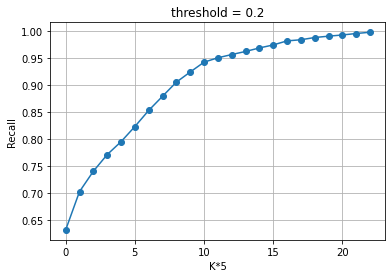

In [28]:
#plot recall vs K

import matplotlib.pyplot as plt 
import numpy as np 

#k.insert(0, '1')
x = k
#answers.insert(0,'0.46')
y=answers

plt.xlabel("K*5")
plt.ylabel("Recall")
plt.title('threshold = 0.2')
plt.plot(y, marker = 'o')
plt.grid()
plt.show()  

## Retrieval function

In [12]:
#Acesso ao drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from collections import Counter
import json
import re
import numpy as np

def read_list_of_ids(file_path: str):
    with open(file_path) as infile:
        id_lists = infile.read().splitlines()
    return id_lists


# Input files
bert_result_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/results/bertopic_documents-final.csv"
document_references_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/task1_train_labels.json"
embeddings_bin = np.load("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/embedding-vector.npy")
embeddings_list = embeddings_bin.tolist()
list_of_ids = read_list_of_ids("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/list_of_ids")


# print(embeddings_list)


In [ ]:
size = len(queries_to_refs['008447.txt'])
print(size)

In [ ]:
def generate_dominant_map(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Dominant_Topic))

def generate_ids_to_embeddings(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=";")
    return dict(zip(df.Topic, df.Embedding))

def generate_top_k_map(csv_filepath: str, k: int) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    result_map = dict(zip(df.Document_id, df.Top5_Topics)) # TOP 5
    # print("Pre-filtering map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(result_map, k)
    # print("Filtered on top K map:", filtered_map)
    return filtered_map


def remove_all_elements_greater_than_k(input_map : map, cut_value: int):
    new_map = dict()
    for (key, v) in input_map.items():
        l = str_to_list(v)
        new_map[key] = build_str(l, cut_value)
    return new_map


def str_to_list(value: str) -> list:
    cleaned_v = value.replace("]", "").replace("[", "").strip()
    return re.split("\s+", cleaned_v)


def generate_document_map(json_file: str) -> map:
    with open(json_file) as json_data:
        data = json.load(json_data)
        return data

def build_str(l: list, cut_value: int) -> str:
   return "[" + " ".join(l[0:cut_value]) + "]"


def convert_float_to_int_string(value: float) -> str:
    return str(int(float(value)))

# Compute the maps for analysis: 
  #Doc -> Dominant topic
all_docs_to_dominant_topic = generate_dominant_map(bert_result_file)
#print(all_docs_to_dominant_topic) # OK
queries_to_refs = generate_document_map(document_references_file)
#print(queries_to_refs) # OK

# Group docs with the same dominant topic [and define top K] <<<<<
all_docs_to_top_k = generate_top_k_map(bert_result_file, 10) #top K = 10
#print(all_docs_to_top_k) # OK


# Generate list of docs with same dominant topic's group for top K
def add_to_inverted_list(inverted_map, doc, topic):
  if topic not in inverted_map:
    inverted_map[topic] = set()
  inverted_map[topic].add(doc)


def get_inverted_map(all_docs_to_dominant_topic):
  inverted_map = dict()
  for (doc_i, topic_i) in all_docs_to_dominant_topic.items():
    add_to_inverted_list(inverted_map, doc_i, topic_i)
  return inverted_map

inverted_map = get_inverted_map(all_docs_to_dominant_topic)

def queries_to_docs(queries, inverted_map, all_docs_to_top_k):
    query_candidates = dict()
    for query in queries:
        top_k_list = str_to_list(all_docs_to_top_k[query]) # '017190.txt': '[66 105 19 35]'
        query_candidates[query] = set()
        for topic in top_k_list:
            inv_list = inverted_map[float(topic)]
  #          print("For dominant:", topic, "size: ", len(inv_list))
            query_candidates[query] = query_candidates[query].union(inv_list)
   #         print("Candidates after union with topic:", topic, ", size: ",len(query_candidates[query]))
    #        print("Final candidates for topic ", topic, ", size:", len(query_candidates[query]))
    return query_candidates

def write_doc_to_embeddings(map: map, filename: str) -> None:
  #  print("To write at file: " + "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/"+filename)
    with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/"+filename,'w',encoding = 'utf-8') as f:
        f.write("query,candidates_embeddings\n")
        for (k,v) in map.items():
            f.write( str(k) + ";" + str(v) + "\n" )


query_candidates = queries_to_docs(queries_to_refs.keys(), inverted_map, all_docs_to_top_k)
# print(queryToDocs['008447.txt'])
# print(inverted_map)
# print(inverted_map[21.0].union(inverted_map[18.0]))
# print(len(inverted_map[117.0]))

def convert_doc_ids_to_embeddings(query_candidates :map, ids_to_embeddings: map) -> map:
    query_embeddings = dict()
    for (query, candidates) in query_candidates.items():
        query_embeddings[query] = [ids_to_embeddings[candidate] for candidate in candidates]
    return query_embeddings



ids_to_embeddings = dict(zip(list_of_ids, embeddings_list))
# print(ids_to_embeddings)

query_to_embeddings = convert_doc_ids_to_embeddings(query_candidates, ids_to_embeddings)
# print(query_to_embeddings)
#write_doc_to_embeddings(query_to_embeddings, "query_to_embeddings")


from sklearn.metrics.pairwise import cosine_similarity

# key=query, values=candidates

results_raw=dict()
results = dict()
for key, values in query_to_embeddings.items():
  X = np.array(ids_to_embeddings[key]).reshape(1,-1)
  Y = values
  similarities = cosine_similarity(X, Y)
  sim = similarities[0]
  lenght = len(queries_to_refs[key])
  ind = np.argpartition(sim, lenght)[lenght:]
  #ind = np.argpartition(sim, -35)[-35:]   # Pra variar o top N mais similares; pega os N últimos, pq está em ordem crescente;
  top = ind[np.argsort(sim[ind])] # Retorna o indice (original) dos valores no Top N
  value = list(query_candidates[key])
  answers_raw= []
  answers = dict()
  for idx in top:
    if value[idx] != key:
      answers_raw.append(value[idx])
      answers[value[idx]] = sim[idx]
  results[key] = answers
  results_raw[key] = answers_raw


### Final results evaluation

In [ ]:
import statistics

#Checking the biggest number of answers
print(queries_to_refs,'\n')
length_dict = {key: len(value) for key, value in queries_to_refs.items()}
print(length_dict)
print(max(length_dict.values()), 'is the maximum number of answers to a query')

def write_document_map_to_csv(map: map, filename: str) -> None:
    print("To write at file: " + "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename)
    with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename,'w',encoding = 'utf-8') as f:
        f.write("document,percentual\n")
        for (k,v) in map.items():
            f.write( str(k) + "," + str(v) + "\n" )

### Def Precision at N (N = len(results_raw) = 11)
def precision_N(results_raw, queries_to_refs) -> map:
    precision_results= Counter()
    for query,candidates in results_raw.items():
      for candidate in results_raw[query][::-1]:
        if candidate in queries_to_refs[query]:
          precision_results[query] = precision_results[query] +1
      precision_results[query] = precision_results[query] / len(results_raw[query])
    return precision_results

### Def Recall at N (N = len(results_raw))
def recall_N(results_raw, queries_to_refs) ->map:
  recall_results= Counter()
  for query,candidates in results_raw.items():
    for candidate in results_raw[query][::-1]:
      if candidate in queries_to_refs[query]:
        recall_results[query] = recall_results[query] +1
    recall_results[query] = recall_results[query] / len(queries_to_refs[query])
  return recall_results



##Calculate results
#Calculate Precision
precision_N = precision_N(results_raw, queries_to_refs)
print(precision_N)
precision_N_mean = statistics.mean(precision_N.values())
print(precision_N_mean)
#write_document_map_to_csv(precision_N,'Final_precision_N.csv')

#Calculate Recall
recall_N = recall_N(results_raw, queries_to_refs)
#print(recall_N)
recall_N_mean = statistics.mean(recall_N.values())
print(recall_N_mean)
#write_document_map_to_csv(recall_N,'Final_recall_N.csv')



NameError: ignored

In [ ]:
mean_dict = statistics.mean(length_dict.values())
print(mean_dict)

5.093846153846154


In [ ]:
print(recall_N)
print(recall_N['008447.txt'])
print('candidadates: ',results['008447.txt'])
print('gabarito: ', queries_to_refs['008447.txt'][::-1])


Counter({'067501.txt': 1.0, '030394.txt': 1.0, '001499.txt': 1.0, '031284.txt': 1.0, '040560.txt': 1.0, '078681.txt': 1.0, '070711.txt': 1.0, '057136.txt': 1.0, '079913.txt': 1.0, '069872.txt': 1.0, '099856.txt': 1.0, '007137.txt': 1.0, '096028.txt': 1.0, '076365.txt': 1.0, '098576.txt': 1.0, '056717.txt': 1.0, '037710.txt': 1.0, '056909.txt': 1.0, '014411.txt': 1.0, '040801.txt': 1.0, '096695.txt': 1.0, '084828.txt': 1.0, '098780.txt': 1.0, '041233.txt': 1.0, '052766.txt': 1.0, '023818.txt': 1.0, '046310.txt': 1.0, '079200.txt': 1.0, '053170.txt': 1.0, '039086.txt': 1.0, '086250.txt': 1.0, '048477.txt': 1.0, '031532.txt': 1.0, '072292.txt': 1.0, '092346.txt': 1.0, '076286.txt': 1.0, '061781.txt': 1.0, '084496.txt': 1.0, '026686.txt': 1.0, '024927.txt': 1.0, '023005.txt': 1.0, '024409.txt': 1.0, '061129.txt': 1.0, '082829.txt': 1.0, '061177.txt': 1.0, '078150.txt': 1.0, '042740.txt': 1.0, '093057.txt': 1.0, '061521.txt': 1.0, '066101.txt': 1.0, '062618.txt': 1.0, '072069.txt': 1.0, '07

In [ ]:
#from nltk.metrics.scores import recall

  #Verificação PRECISION
#print(results_raw.items())
#query = '008447.txt'
#print('candidadates: ',results_raw[query])
#print('gabarito: ', queries_to_refs[query][::-1])
#print(len(results_raw[query]))
#print(precision_N[query])
#print('precisao: ', 4/34)

##Recall



'''
#4. Pre-selection based on the topics:
#Select only K-Candidate set = docs in the same top K topic as Q
-Para doc ID Q
  -Olha para as referências de Q
    -Se o reference dominant topics is within the document top K topics
      -Salva no vetor pre-selection deste doc

#5. Select the X most similar docs with Q and K-Candidate set
1. Selecionar do docs_embedding apenas os documentos da lista de pre-selection
2. Roda o algoritmo de similaridade
3. Recupera os X mais similares
4. Cria map : doc_id_Q -> doc_id_Answers 

->Fazer isso para todos os itens do vetor


# sm = Similarity()
# sm.compute_cosine_similarity(preprocessed_corpus, list_of_ids)

#Select top X

#embed_query = [Doc2Vec(query)]
#embed_candidatos = [[embed_doc1], [embed_doc2], [embed_doc3]]

#Calculate the cosine similarity
#from sklearn.metrics.pairwise import cosine_similarity
#sim = cosine_similarity(X=embed_query, Y=embed_candidatos)

#ind = np.argpartition(sim, -20)[-20:]
#top = ind[np.argsort(sim[ind])]

'''

#print(doc_to_dominant_topic)
#print(inverted_map)
#print(inverted_map[21.0].union(inverted_map[18.0]))
# print(len(inverted_map[117.0]))

In [ ]:
#save list_of_ids
# open file in write mode
with open(r'/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/list_of_ids', 'w') as fp:
    for id in list_of_ids:
        # write each item on a new line
        fp.write("%s\n" % id)
    print('Done')

print(list_of_ids)

In [ ]:
#Precision

def precision(doc_to_dominant_topic: map, doc_to_refs: map, lista_precision): 
 result = Counter()
 for (doc, v) in doc_to_refs.items():
   for ref in doc_to_refs[doc]:
    if (doc_to_dominant_topic[ref] == doc_to_dominant_topic[doc]):
     result[doc] = result[doc] + 1
   result[doc] = result[doc] / precision_docs[doc_to_dominant_topic[doc]]
 return result

print(precision_docs, '\n')
print(doc_to_dominant_topic)
print(precision_docs[doc_to_dominant_topic['021359.txt']])

#print(precision_docs, '\n')
#print(doc_to_dominant_topic, '\n')
#print(doc_to_refs['030394.txt'],'\n')
#print(doc_to_refs.items(), '\n')
#print(precision_docs[doc_to_dominant_topic['030394.txt']])

def precision(doc_to_dominant_topic: map, doc_to_refs: map, lista_precision): 
 result = Counter()
 for (doc, v) in doc_to_refs.items():
   for ref in doc_to_refs[doc]:
    if (doc_to_dominant_topic[ref] == doc_to_dominant_topic[doc]):
     result[doc] = result[doc] + 1
   result[doc] = result[doc] / precision_docs[doc_to_dominant_topic[doc]]
 return result

# transform doc_to_dominant_topic in df
doc_to_dominant_df = pd.DataFrame(doc_to_dominant_topic.items(), columns=['Doc', 'Topic'])
# Count how many times each topic is found (most common)
series = doc_to_dominant_df['Topic'].value_counts()
# Convert to data frame
precision_docs = series.to_frame('Total_Docs') 
# Add index as a new column
precision_docs['Topic'] = list(precision_docs.index)
# Reset the index
precision_docs = precision_docs.sort_values('Topic')
precision_docs = precision_docs.reset_index(drop=True)
precision_docs = precision_docs.reindex(columns=['Topic','Total_Docs'])
#convert to dict
precision_docs = dict(precision_docs.values)
